# **Spiking Hopfield Network Project Notebook**

## Implementation of Hopfield Network using snntorch (Spiking) with LIF Neurons**

In [1]:
#install snntorch
!pip install snntorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.3/125.3 kB 5.4 MB/s eta 0:00:00


In [9]:
#import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm
import skimage.data
from skimage.color import rgb2gray
from skimage.filters import threshold_mean
from skimage.transform import resize
import torch
import torch.nn as nn
import os
import torchvision.transforms as transforms
from PIL import Image
import snntorch as snn
import snntorch.spikegen as spikegen
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [3]:
#set the device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
#mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#Define the spiking Hopfield Network class
class SpikingHopfieldNetwork(nn.Module):
    def __init__(self, num_steps, beta, reset_mechanism, threshold_lif):
        super().__init__()

        self.num_steps = num_steps
        self.beta = beta
        self.reset_mechanism = reset_mechanism
        self.threshold_lif = threshold_lif

    def train_weights(self, train_data):
        print("Start to train weights...")
        num_data = len(train_data)
        self.num_neuron = train_data[0].shape[0]
        self.lif_neuron = snn.Leaky(beta=self.beta, reset_mechanism= self.reset_mechanism, threshold= self.threshold_lif).to(device)


        # initialize weights
        W = torch.zeros((self.num_neuron, self.num_neuron)).to(device)
        rho = torch.sum(torch.stack([torch.sum(t) for t in train_data])).to(device) / (num_data * self.num_neuron)

        # Hebb rule
        for i in tqdm(range(num_data)):
            t = train_data[i] - rho
            W += torch.ger(t, t)

        # Make diagonal element of W into 0
        diagW = torch.diag(torch.diag(W)).to(device)
        W = W - diagW
        W /= num_data

        self.W = W.to(device)
        torch.cuda.empty_cache()

    def predict(self, data, num_iter=20, threshold=0, asyn=False):
        print("Start to predict...")
        self.num_iter = num_iter
        self.threshold = threshold
        self.asyn = asyn

        # Copy to avoid call by reference
        copied_data = [d for d in data]
        stacked_copied_data = torch.stack(copied_data)

        spiked_data = spikegen.rate(stacked_copied_data, num_steps=self.num_steps)

        # Define predict list
        predicted = []
        spike_counts = []

        for i in tqdm(range(len(data))):
            vmem = self.lif_neuron.reset_mem()
            image_prediction = []
            image_spike_count = []
            all_spk = []
            all_vmem = []

            for step in range(self.num_steps):
                result, spikes = self._run(spiked_data[step][i], vmem, all_spk, all_vmem)
                image_prediction.append(result)
                image_spike_count.append(spikes)
            predicted.append(image_prediction[-1])
            spike_counts.append(image_spike_count)

        total_spikes = sum(sum(row) for row in spike_counts)
        print('Total Number of spikes:',total_spikes)

        return predicted

    def _run(self, init_s, vmem, all_spk, all_vmem):
        num_spikes = 0

        if not self.asyn:
            s = init_s.clone().to(device)
            #print("Input Data:", s[:2])
            spk, vmem = self.lif_neuron(s)

            #print("Spike Data:",spk[:2])
            e = self.energy(vmem)

            for i in range(self.num_iter):
                s1 = torch.sign(self.W @ vmem - self.threshold).to(device)
                e_new = self.energy(s1)

                if e == e_new:
                    return s1, num_spikes

                num_spikes += torch.sum(spk).item()
                e = e_new
                all_spk.append(spk)
                all_vmem.append(vmem)
            return s1, num_spikes, all_spk, all_vmem

        else:
            s = init_s.clone().to(device)
            spk, vmem = self.lif_neuron(s)
            e = self.energy(spk)

            for i in range(self.num_iter):
                for j in range(100):
                    idx = torch.randint(0, self.num_neuron, (1,)).item()
                    s1[idx] = torch.sign(self.W[idx].T @ spk - self.threshold).to(device)

                e_new = self.energy(s1)

                if e == e_new:
                    return s1, num_spikes

                num_spikes += torch.sum(spk).item()

                e = e_new

                all_spk.append(spk)
                all_vmem.append(vmem)

            return s1, num_spikes, all_spk, all_vmem

    def energy(self, s):
        return -0.5 * s @ self.W @ s + torch.sum(s * self.threshold).to(device)


    def plot_weights(self):
        plt.figure(figsize=(6, 5))
        w_mat = plt.imshow(self.W.cpu(), cmap=cm.coolwarm)
        plt.colorbar(w_mat)
        plt.title("Network Weights")
        plt.tight_layout()
        plt.savefig("weights.png")
        plt.show()

In [6]:
#utilis
#Utility functions
def get_corrupted_input(input, corruption_level):
    """
    Corrupts the input data by randomly inverting the signs of the elements
    based on the given corruption level.
    """
    corrupted = input.clone().to(device)
    inv = torch.bernoulli(torch.full_like(corrupted, corruption_level)).to(device)
    corrupted[inv.bool()] *= -1
    return corrupted

def reshape(data, original_shape=None):
    """
    Reshapes the input data to a square if no shape is given or to the specified shape.
    """
    if original_shape is not None:
        # Reshape to specified shape
        return data.view(original_shape).to(device)

    else:
        # Reshape to a square shape
        dim = int(np.sqrt(data.numel()))
        return data.view(dim, dim).to(device)

def plot(data, test, predicted, figsize=(5, 6), shape=None, save_as="result_combined.png"):
    """
    Plots training data, input data, and predicted data side by side.
    """
    data = [reshape(torch.tensor(d, device=device), original_shape=shape).cpu().numpy() for d in data]
    test = [reshape(torch.tensor(d, device=device), original_shape=shape).cpu().numpy() for d in test]
    predicted = [reshape(torch.tensor(d, device=device), original_shape=shape).cpu().numpy() for d in predicted]

    fig, axarr = plt.subplots(len(data), 3, figsize=figsize)
    for i in range(len(data)):
        if i == 0:
            axarr[i, 0].set_title('Train data')
            axarr[i, 1].set_title('Input data')
            axarr[i, 2].set_title('Output data')

        axarr[i, 0].imshow(data[i])
        axarr[i, 0].axis('off')
        axarr[i, 1].imshow(test[i])
        axarr[i, 1].axis('off')
        axarr[i, 2].imshow(predicted[i])
        axarr[i, 2].axis('off')

    plt.tight_layout()
    plt.savefig(save_as)
    plt.show()

def preprocessing(img, w=None, h=None):
    # Determine whether resizing is needed
    if w is not None and h is not None:
        # Resize the image if width and height are specified
        img = resize(img, (w, h), mode='reflect')
    else:
        # Use the original dimensions if width and height are not specified
        w, h = img.shape

    # Thresholding
    thresh = threshold_mean(img)
    binary = img > thresh
    shift = 2 * (binary.astype(np.float32) * 1) - 1  # Boolean to int conversion

    # Reshape to flatten the image
    flatten = torch.tensor(shift.flatten(), dtype=torch.float32).to(device)
    return flatten

Start to data preprocessing...
Start to train weights...


100%|██████████| 3/3 [00:00<00:00, 43.77it/s]


Start to predict...


100%|██████████| 3/3 [00:00<00:00,  3.56it/s]
<ipython-input-6-35590fb3e732>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = [reshape(torch.tensor(d, device=device), original_shape=shape).cpu().numpy() for d in data]
<ipython-input-6-35590fb3e732>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test = [reshape(torch.tensor(d, device=device), original_shape=shape).cpu().numpy() for d in test]
<ipython-input-6-35590fb3e732>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted = [reshape(torch.tensor(d, device=device), orig

Total Number of spikes: 129895.0
Show prediction results...


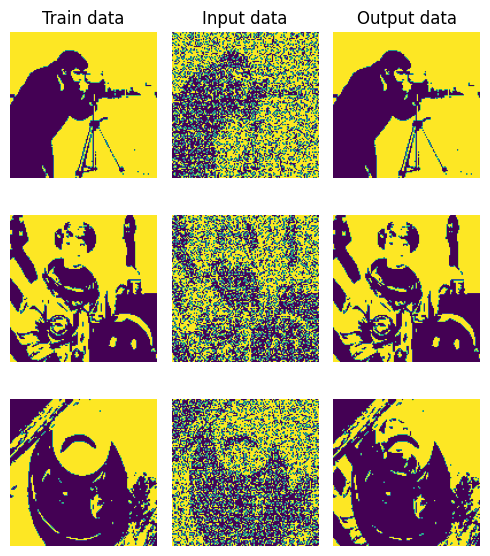

In [7]:
if __name__ == '__main__':
    # Load data
    camera = skimage.data.camera()
    astronaut = rgb2gray(skimage.data.astronaut())
    coffee = rgb2gray(skimage.data.coffee())

    # Marge data
    data = [camera, astronaut, coffee]

    # Preprocessing
    print("Start to data preprocessing...")
    data = [preprocessing(d,128,128) for d in data]

    # Create Hopfield Network Model
    model = SpikingHopfieldNetwork(num_steps= 10, beta = 0.9, reset_mechanism='zero', threshold_lif = 1.0).to(device) #Change the number of time steps as needed
    model.train_weights(data)

    # Generate testset
    test = [get_corrupted_input(d, 0.3) for d in data]

    predicted = model.predict(test, threshold=1, asyn=False)
    print("Show prediction results...")
    plot(data, test, predicted)

Start to data preprocessing...
Start to train weights...


100%|██████████| 3/3 [00:00<00:00, 1100.58it/s]


Start to predict...


100%|██████████| 3/3 [00:00<00:00,  4.75it/s]
<ipython-input-6-35590fb3e732>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = [reshape(torch.tensor(d, device=device), original_shape=shape).cpu().numpy() for d in data]
<ipython-input-6-35590fb3e732>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test = [reshape(torch.tensor(d, device=device), original_shape=shape).cpu().numpy() for d in test]
<ipython-input-6-35590fb3e732>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted = [reshape(torch.tensor(d, device=device), orig

Total Number of spikes: 123380.0
Show prediction results...


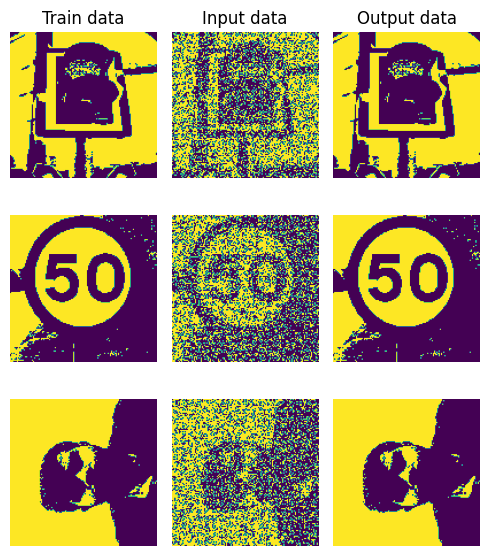

In [10]:
if __name__ == '__main__':
    # Load data
    traffic_sign = '/content/drive/MyDrive/Hopfield Network_Upd/Road_Sign_Images/images/road5.png'
    speed_sign = '/content/drive/MyDrive/Hopfield Network_Upd/Road_Sign_Images/images/road100.png'
    phone_img = '/content/drive/MyDrive/Hopfield Network_Upd/Road_Sign_Images/images/IMG_1968.JPG'

    # Marge data
    data = [
        img_to_array(load_img(traffic_sign, target_size=(128, 128), color_mode='grayscale'))[:, :, 0],
        img_to_array(load_img(speed_sign, target_size=(128, 128), color_mode='grayscale'))[:, :, 0],
        img_to_array(load_img(phone_img, target_size=(128, 128), color_mode='grayscale'))[:, :, 0],
    ]

    # Preprocessing
    print("Start to data preprocessing...")
    data = [preprocessing(d,128,128) for d in data]

    # Create Hopfield Network Model
    model = SpikingHopfieldNetwork(num_steps= 10, beta = 0.9, reset_mechanism='zero', threshold_lif = 1.0).to(device) #Change the number of time steps as needed
    model.train_weights(data)

    # Generate testset
    test = [get_corrupted_input(d, 0.3) for d in data]

    predicted = model.predict(test, threshold=0, asyn=False)
    print("Show prediction results...")
    plot(data, test, predicted)

## Analyze Number of Spikes for different time steps

### **Time Steps - 10**

Start to data preprocessing...
Start to train weights...


100%|██████████| 3/3 [00:00<00:00, 6601.74it/s]


Start to predict...


100%|██████████| 3/3 [00:00<00:00,  4.74it/s]
<ipython-input-6-35590fb3e732>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = [reshape(torch.tensor(d, device=device), original_shape=shape).cpu().numpy() for d in data]
<ipython-input-6-35590fb3e732>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test = [reshape(torch.tensor(d, device=device), original_shape=shape).cpu().numpy() for d in test]
<ipython-input-6-35590fb3e732>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted = [reshape(torch.tensor(d, device=device), orig

Total Number of spikes: 124155.0
Show prediction results...


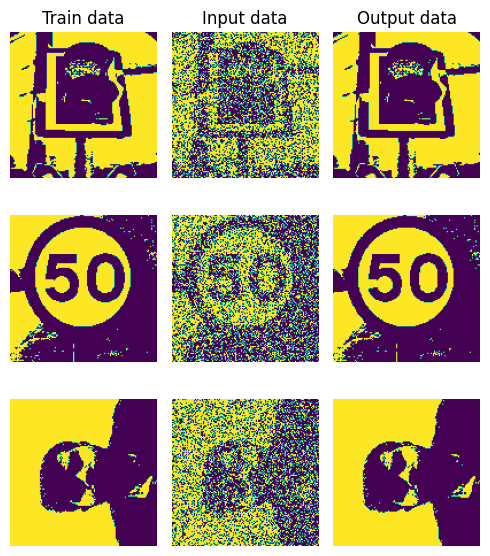

In [11]:
if __name__ == '__main__':
    # Load data
    traffic_sign = '/content/drive/MyDrive/Hopfield Network_Upd/Road_Sign_Images/images/road5.png'
    speed_sign = '/content/drive/MyDrive/Hopfield Network_Upd/Road_Sign_Images/images/road100.png'
    phone_img = '/content/drive/MyDrive/Hopfield Network_Upd/Road_Sign_Images/images/IMG_1968.JPG'

    # Marge data
    data = [
        img_to_array(load_img(traffic_sign, target_size=(128, 128), color_mode='grayscale'))[:, :, 0],
        img_to_array(load_img(speed_sign, target_size=(128, 128), color_mode='grayscale'))[:, :, 0],
        img_to_array(load_img(phone_img, target_size=(128, 128), color_mode='grayscale'))[:, :, 0],
    ]

    # Preprocessing
    print("Start to data preprocessing...")
    data = [preprocessing(d,128,128) for d in data]

    # Create Hopfield Network Model
    model = SpikingHopfieldNetwork(num_steps= 10, beta = 0.9, reset_mechanism='zero', threshold_lif = 1.0).to(device) #Change the number of time steps as needed
    model.train_weights(data)

    # Generate testset
    test = [get_corrupted_input(d, 0.3) for d in data]

    predicted = model.predict(test, threshold=0, asyn=False)
    print("Show prediction results...")
    plot(data, test, predicted)

### **Time Steps - 50**

Start to data preprocessing...
Start to train weights...


100%|██████████| 3/3 [00:00<00:00, 1972.24it/s]


Start to predict...


100%|██████████| 3/3 [00:03<00:00,  1.03s/it]
<ipython-input-6-35590fb3e732>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = [reshape(torch.tensor(d, device=device), original_shape=shape).cpu().numpy() for d in data]
<ipython-input-6-35590fb3e732>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test = [reshape(torch.tensor(d, device=device), original_shape=shape).cpu().numpy() for d in test]
<ipython-input-6-35590fb3e732>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted = [reshape(torch.tensor(d, device=device), orig

Total Number of spikes: 614550.0
Show prediction results...


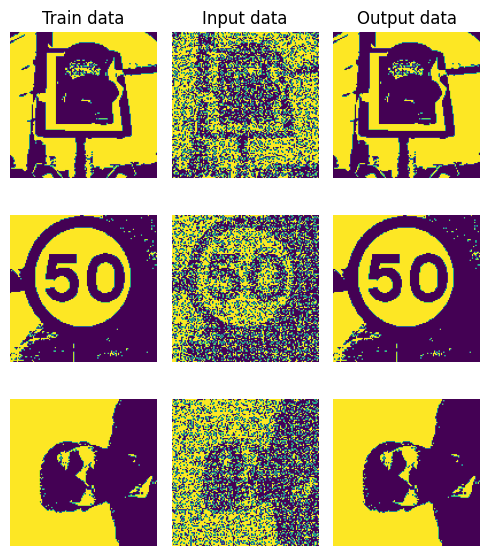

In [12]:
if __name__ == '__main__':
    # Load data
    traffic_sign = '/content/drive/MyDrive/Hopfield Network_Upd/Road_Sign_Images/images/road5.png'
    speed_sign = '/content/drive/MyDrive/Hopfield Network_Upd/Road_Sign_Images/images/road100.png'
    phone_img = '/content/drive/MyDrive/Hopfield Network_Upd/Road_Sign_Images/images/IMG_1968.JPG'

    # Marge data
    data = [
        img_to_array(load_img(traffic_sign, target_size=(128, 128), color_mode='grayscale'))[:, :, 0],
        img_to_array(load_img(speed_sign, target_size=(128, 128), color_mode='grayscale'))[:, :, 0],
        img_to_array(load_img(phone_img, target_size=(128, 128), color_mode='grayscale'))[:, :, 0],
    ]

    # Preprocessing
    print("Start to data preprocessing...")
    data = [preprocessing(d,128,128) for d in data]

    # Create Hopfield Network Model
    model = SpikingHopfieldNetwork(num_steps= 50, beta = 0.9, reset_mechanism='zero', threshold_lif = 1.0).to(device) #Change the number of time steps as needed
    model.train_weights(data)

    # Generate testset
    test = [get_corrupted_input(d, 0.3) for d in data]

    predicted = model.predict(test, threshold=0, asyn=False)
    print("Show prediction results...")
    plot(data, test, predicted)

### **Time Steps - 100**

Start to data preprocessing...
Start to train weights...


100%|██████████| 3/3 [00:00<00:00, 3512.82it/s]


Start to predict...


100%|██████████| 3/3 [00:06<00:00,  2.07s/it]
<ipython-input-6-35590fb3e732>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = [reshape(torch.tensor(d, device=device), original_shape=shape).cpu().numpy() for d in data]
<ipython-input-6-35590fb3e732>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test = [reshape(torch.tensor(d, device=device), original_shape=shape).cpu().numpy() for d in test]
<ipython-input-6-35590fb3e732>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted = [reshape(torch.tensor(d, device=device), orig

Total Number of spikes: 1228600.0
Show prediction results...


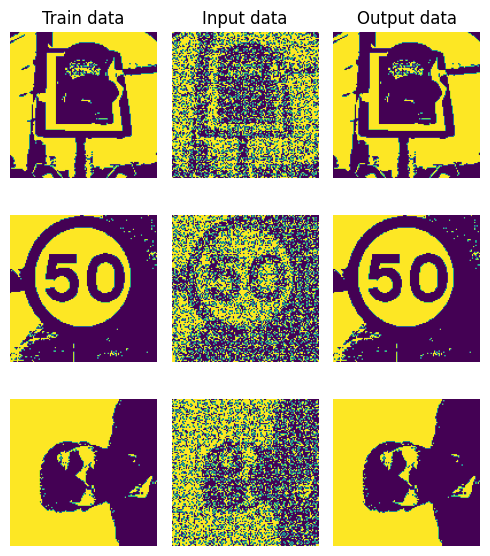

In [13]:
if __name__ == '__main__':
    # Load data
    traffic_sign = '/content/drive/MyDrive/Hopfield Network_Upd/Road_Sign_Images/images/road5.png'
    speed_sign = '/content/drive/MyDrive/Hopfield Network_Upd/Road_Sign_Images/images/road100.png'
    phone_img = '/content/drive/MyDrive/Hopfield Network_Upd/Road_Sign_Images/images/IMG_1968.JPG'

    # Marge data
    data = [
        img_to_array(load_img(traffic_sign, target_size=(128, 128), color_mode='grayscale'))[:, :, 0],
        img_to_array(load_img(speed_sign, target_size=(128, 128), color_mode='grayscale'))[:, :, 0],
        img_to_array(load_img(phone_img, target_size=(128, 128), color_mode='grayscale'))[:, :, 0],
    ]

    # Preprocessing
    print("Start to data preprocessing...")
    data = [preprocessing(d,128,128) for d in data]

    # Create Hopfield Network Model
    model = SpikingHopfieldNetwork(num_steps= 100, beta = 0.9, reset_mechanism='zero', threshold_lif = 1.0).to(device) #Change the number of time steps as needed
    model.train_weights(data)

    # Generate testset
    test = [get_corrupted_input(d, 0.3) for d in data]

    predicted = model.predict(test, threshold=0, asyn=False)
    print("Show prediction results...")
    plot(data, test, predicted)

**The number of spikes are reported in the output for all time steps**